In [1]:
import itertools

import numpy as np
import keras
from keras.applications.resnet50 import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
batch_size = 32
num_classes = 2
epochs = 50
img_rows, img_cols = 256, 256

In [3]:
# the data, shuffled and split between train and test sets
npz = np.load('data/data.npz')
x_train = npz['x_train']
y_train = npz['y_train']
x_test = npz['x_test']
y_test = npz['y_test']
x_train = x_train[:,:,:,0:3]
x_test = x_test[:,:,:,0:3]

In [4]:
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 3, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 3, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 3)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (1696, 256, 256, 3)
1696 train samples
425 test samples


In [5]:
# weight classes to account for differences in class frequencies
non_background = np.sum(y_train, axis=0)[1]
class_weight = {
    0: 1,
    1: (y_train.shape[0] - non_background) / non_background
}

In [6]:
# normalize the images
x_train /= 255
x_test /= 255

img_mean = np.mean(x_train, axis=(0, 1, 2))
img_std = np.std(x_train, axis=(0, 1, 2))
x_train -= img_mean
x_train /= img_std

x_test -= img_mean
x_test /= img_std


In [7]:
model = ResNet50(weights=None,
                 input_shape=input_shape,
                 classes=num_classes)

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(lr = 1e-4),
              metrics=['accuracy'])


datagen = ImageDataGenerator(
    rotation_range=180,  # randomly rotate images in the range (degrees, 0 to 180)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False
)

In [8]:
# Fit the model on the batches generated by datagen.flow().
model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=int(x_train.shape[0] / batch_size),
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    verbose=1,
                    class_weight=class_weight,
                    workers=4)

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
model.save('model.h5')

Epoch 1/50
53/53 [==============================] - 66s 1s/step - loss: 0.5306 - acc: 0.6722 - val_loss: 1.0586 - val_acc: 0.6682
Epoch 2/50
53/53 [==============================] - 47s 892ms/step - loss: 0.4115 - acc: 0.7270 - val_loss: 1.5405 - val_acc: 0.6424
Epoch 3/50
53/53 [==============================] - 47s 891ms/step - loss: 0.3624 - acc: 0.7482 - val_loss: 1.8492 - val_acc: 0.6824
Epoch 4/50
53/53 [==============================] - 47s 891ms/step - loss: 0.3521 - acc: 0.7594 - val_loss: 1.7304 - val_acc: 0.5435
Epoch 5/50
53/53 [==============================] - 47s 892ms/step - loss: 0.3465 - acc: 0.7512 - val_loss: 0.8637 - val_acc: 0.7741
Epoch 6/50
53/53 [==============================] - 47s 894ms/step - loss: 0.3096 - acc: 0.7777 - val_loss: 1.0790 - val_acc: 0.7365
Epoch 7/50
53/53 [==============================] - 47s 892ms/step - loss: 0.4549 - acc: 0.7400 - val_loss: 0.8983 - val_acc: 0.7694
Epoch 8/50
53/53 [==============================] - 47s 896ms/step - los

In [9]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization


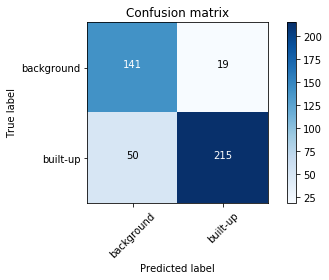

In [10]:
predictions = np.argmax(model.predict(x_test), axis=1)
y_test_pred = np.argmax(y_test, axis=1)
cnf_matrix = confusion_matrix(y_test_pred, predictions)
plot_confusion_matrix(cnf_matrix, ['background', 'built-up'])